# Dreamer vs SAC

In [195]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from importlib import reload
import visualise_speed as vs
reload(vs)

from celluloid import Camera
from IPython.display import clear_output
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import warnings
import os
warnings.filterwarnings('ignore')

from IPython.display import clear_output
from IPython.display import Video

## Individual Dreamer runs
#### Setup
* I did 5 runs with Dremer to 10000 environment steps. On the technical side everything works well.
* Training is not too slow. Training takes about 45 seconds per episode + maybe 15 seconds to transfer data. Altogether on average 40 minutes for a run.
* Constant speed of 0.5
* The best performance with a pretty lucky start was just **10 episodes to converge with just 55 seconds of driving.** If this was achieved constantly one could just stick a GTX3090 into computer and this would make for a pretty cool live demo on reinforcement learning.

#### Qualitative observations
* In run 3 Dreamer initially learned a really risky strategy of driving on the edge of the track which caused it to easily drive off at any time. This is clearly visible in the trajectory plot.
* With a good start Dreamer can learn to drive really fast and accurately like in Run 2
* The policy is pretty stable. Not limiting steering difference in steering between steps causes the wheels to zigzag quite a bit.

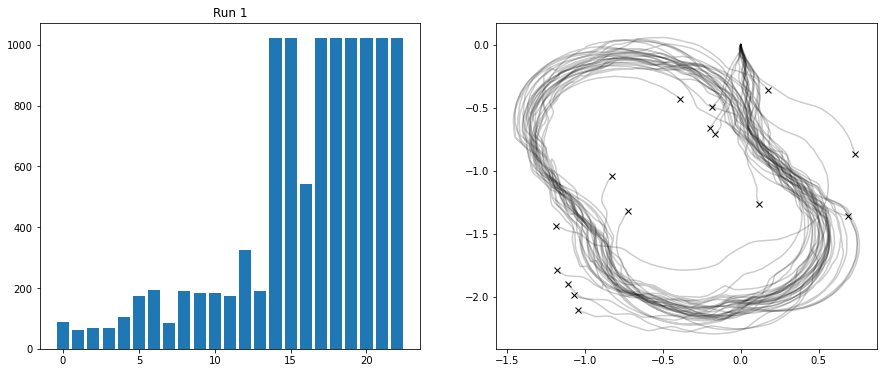

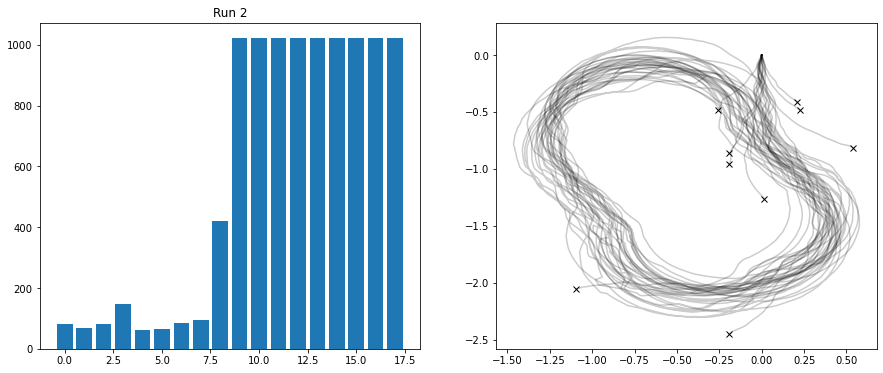

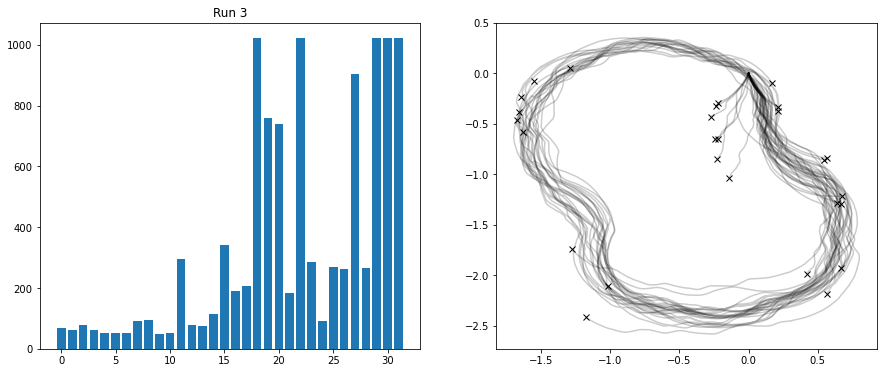

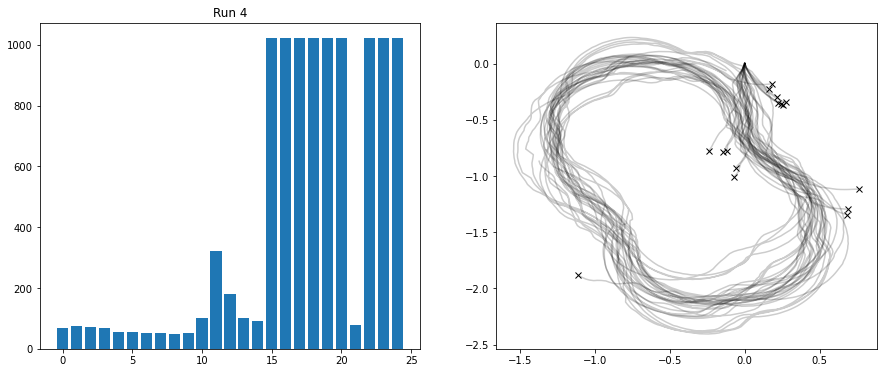

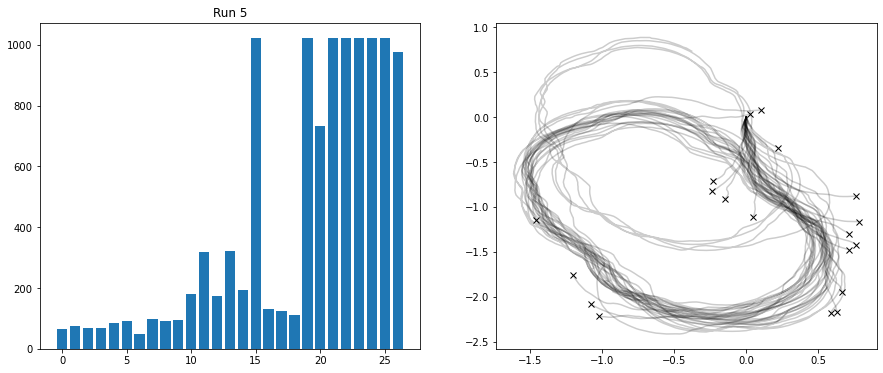

In [162]:
files = sorted(os.listdir("../records/dreamer_local_control/"))
runs = files[-5:]

for i, r in enumerate(runs):
    plt.figure(1, (15, 6))
    data = vs.load_data(f"../records/dreamer_local_control/{r}")
    data = data[data.Step > 20]
    episode_lengths = data.groupby("Episode").max().Step
    cum_env_steps = data.groupby("Episode").max().Step.cumsum()
    total += zip(cum_env_steps, episode_lengths)
    plt.subplot(1, 2, 1)
    plt.bar(np.arange(len(episode_lengths)), episode_lengths)
    plt.title(f"Run {i + 1}")
    plt.subplot(1, 2, 2)
    for e in range(data.Episode.max()):
        ep = data[data.Episode == e]
        if len(ep) > 0:
            plt.plot(ep.PosX, ep.PosZ, color="k", alpha=0.2)
            if len(ep) < 1000:
                plt.plot(ep.PosX.values[-1], ep.PosZ.values[-1], marker="x", color = "k")
    plt.show()

## For comparison, this is how SAC runs look like
* Comparison might not be completely fair because of the mirror image augmentation in SAC but I think these are pretty represtentive. The speed is comparable.
* SAC also has a limit on stepwise change in throttle that probably smooths the trajectories.

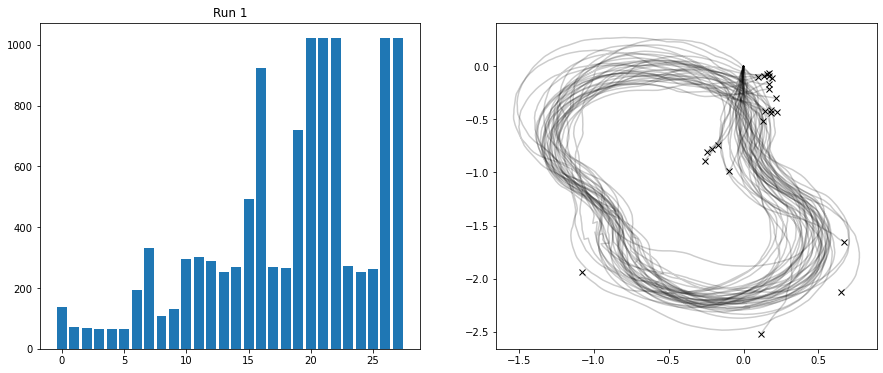

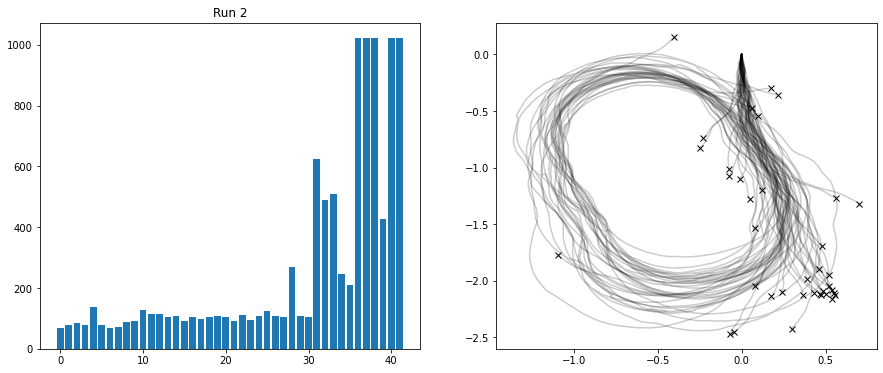

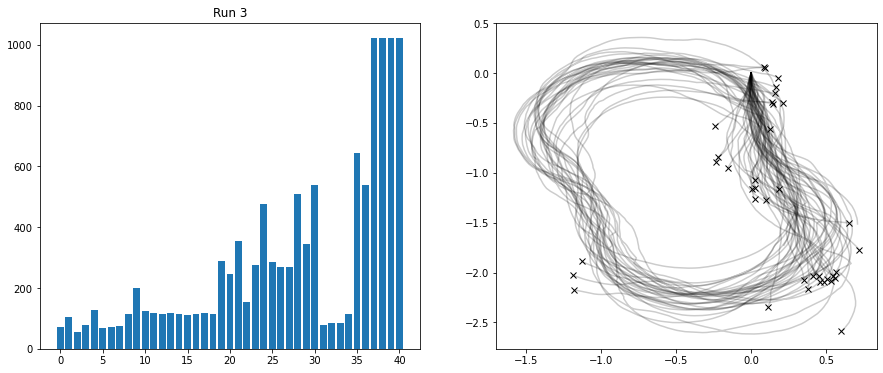

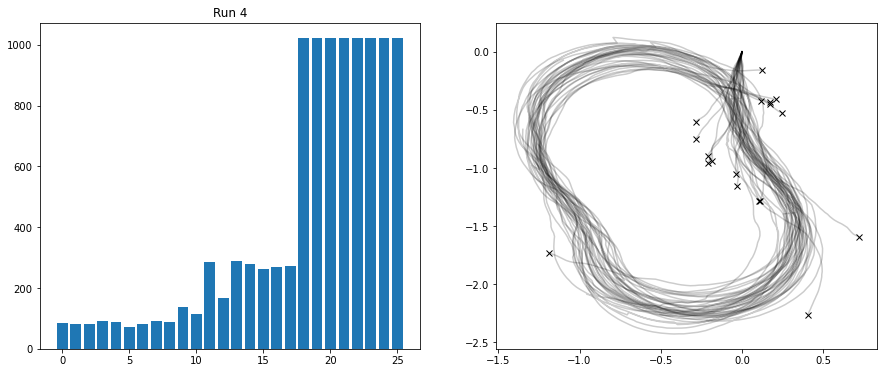

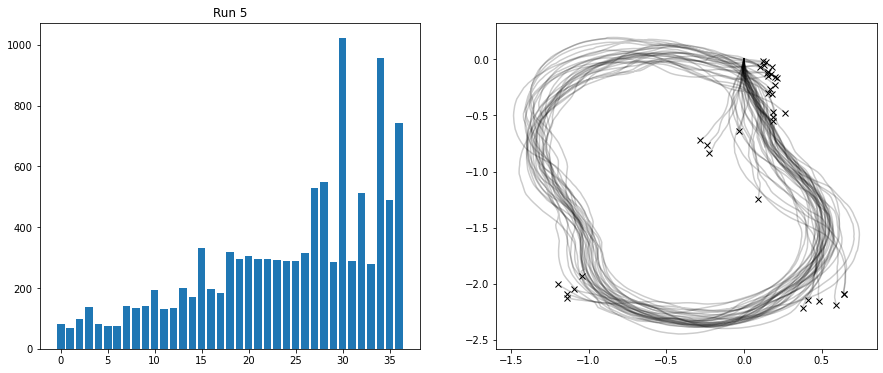

In [163]:
files = sorted(os.listdir("../records/local_control/"))
runs = files[-5:]

for i, r in enumerate(runs):
    plt.figure(1, (15, 6))
    data = vs.load_data(f"../records/local_control/{r}")
    data = data[data.Step > 20]
    episode_lengths = data.groupby("Episode").max().Step
    cum_env_steps = data.groupby("Episode").max().Step.cumsum()
    total += zip(cum_env_steps, episode_lengths)
    plt.subplot(1, 2, 1)
    plt.bar(np.arange(len(episode_lengths)), episode_lengths)
    plt.title(f"Run {i + 1}")
    plt.subplot(1, 2, 2)
    for e in range(data.Episode.max()):
        ep = data[data.Episode == e]
        if len(ep) > 0:
            plt.plot(ep.PosX, ep.PosZ, color="k", alpha=0.2)
            if len(ep) < 1000:
                plt.plot(ep.PosX.values[-1], ep.PosZ.values[-1], marker="x", color = "k")
            
    plt.show()

## Dreamer runs as a function of environment steps
All runs except run 3 pretty much converged by 4000 environment steps or 3 minutes of driving. Run 2 converged in 1100 steps or 55 seconds of driving.

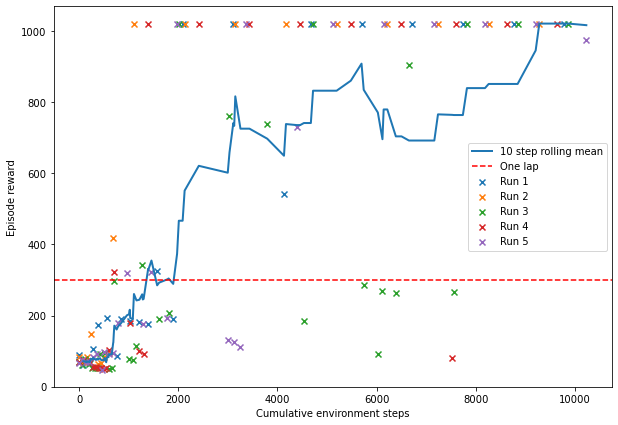

In [148]:
files = sorted(os.listdir("../records/dreamer_local_control/"))
runs = files[-5:]

total = []

plt.figure(1, (10, 7))
for i, r in enumerate(runs):
    data = vs.load_data(f"../records/dreamer_local_control/{r}")
    data = data[data.Step > 20]
    episode_lengths = data.groupby("Episode").max().Step
    cum_env_steps = [0] + list(data.groupby("Episode").max().Step.cumsum()[:-1])
    total += zip(cum_env_steps, episode_lengths)
    plt.scatter(cum_env_steps, episode_lengths, marker="x", alpha=1, label=f"Run {i + 1}")
    #plt.plot(cum_env_steps, episode_lengths.rolling(3).mean())
    
total.sort(key=lambda x: x[0])
           
all_cum_steps = [x[0] for x in total]
all_episode_lengths = [x[1] for x in total]
           
step_rewards = pd.DataFrame(data={"steps": all_cum_steps, "reward": all_episode_lengths})

plt.plot(step_rewards.steps, step_rewards.reward.rolling(10).mean(), linewidth=2, label="10 step rolling mean")
plt.axhline(300, linestyle="--", color="r", label="One lap")
plt.xlabel("Cumulative environment steps")
plt.ylabel("Episode reward")
plt.legend()
plt.show()

## Learning in episode steps compared to SAC with standard deaviation
* Arguably, Dreamer learns faster but more and longer runs would reduce variance and prove convergence.


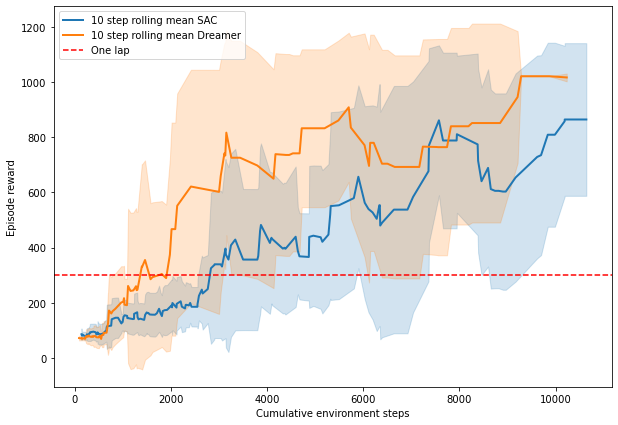

In [140]:
lag=10

files = sorted(os.listdir("../records/local_control/"))
runs = files[-5:]

total = []

plt.figure(1, (10, 7))
for r in runs:
    data = vs.load_data(f"../records/local_control/{r}")
    data = data[data.Step > 20]
    episode_lengths = data.groupby("Episode").max().Step
    cum_env_steps = [0] + list(data.groupby("Episode").max().Step.cumsum()[:-1])
    total += zip(cum_env_steps, episode_lengths)
    #plt.scatter(cum_env_steps, episode_lengths, color="C0", marker="x", alpha=0.5)
    
total.sort(key=lambda x: x[0])
           
all_cum_steps = [x[0] for x in total]
all_episode_lengths = [x[1] for x in total]
           
step_rewards = pd.DataFrame(data={"steps": all_cum_steps, "reward": all_episode_lengths})

mean = step_rewards.reward.rolling(lag).mean()
std = step_rewards.reward.rolling(lag).std()

plt.plot(step_rewards.steps, mean, linewidth=2, label="10 step rolling mean SAC", color="C0")
plt.fill_between(step_rewards.steps, mean - std, mean + std, color="C0", alpha=0.2)

files = sorted(os.listdir("../records/dreamer_local_control/"))
runs = files[-5:]

total = []

plt.figure(1, (10, 7))
for r in runs:
    data = vs.load_data(f"../records/dreamer_local_control/{r}")
    data = data[data.Step > 20]
    episode_lengths = data.groupby("Episode").max().Step
    cum_env_steps = [0] + list(data.groupby("Episode").max().Step.cumsum()[:-1])
    total += zip(cum_env_steps, episode_lengths)
    #plt.scatter(cum_env_steps, episode_lengths, color="C1", marker="x", alpha=0.5)
    #plt.plot(cum_env_steps, episode_lengths)
    
total.sort(key=lambda x: x[0])
           
all_cum_steps = [x[0] for x in total]
all_episode_lengths = [x[1] for x in total]
           
step_rewards = pd.DataFrame(data={"steps": all_cum_steps, "reward": all_episode_lengths})

mean = step_rewards.reward.rolling(lag).mean()
std = step_rewards.reward.rolling(lag).std()

plt.plot(step_rewards.steps, mean, linewidth=2, label="10 step rolling mean Dreamer", color="C1")
plt.fill_between(step_rewards.steps, mean - std, mean + std, color="C1", alpha=0.2)

plt.axhline(300, linestyle="--", color="r", label="One lap")

plt.xlabel("Cumulative environment steps")
plt.ylabel("Episode reward")
plt.legend(loc="upper left")
plt.show()

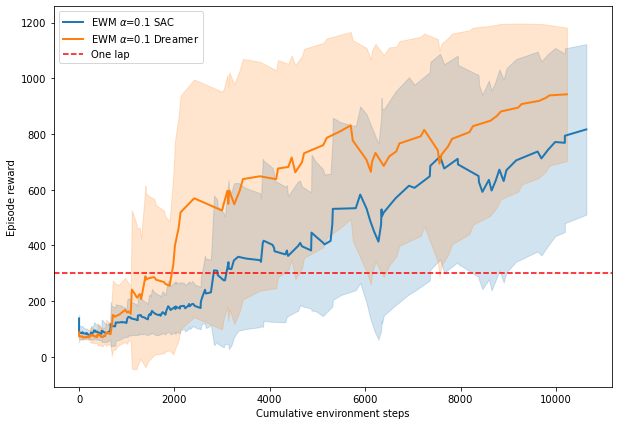

In [141]:
alpha = 0.1

files = sorted(os.listdir("../records/local_control/"))
runs = files[-5:]

total = []

plt.figure(1, (10, 7))
for r in runs:
    data = vs.load_data(f"../records/local_control/{r}")
    data = data[data.Step > 20]
    episode_lengths = data.groupby("Episode").max().Step
    cum_env_steps = [0] + list(data.groupby("Episode").max().Step.cumsum()[:-1])
    total += zip(cum_env_steps, episode_lengths)
    #plt.scatter(cum_env_steps, episode_lengths, color="k", marker="x", alpha=0.5)
    
total.sort(key=lambda x: x[0])
           
all_cum_steps = [x[0] for x in total]
all_episode_lengths = [x[1] for x in total]
           
step_rewards = pd.DataFrame(data={"steps": all_cum_steps, "reward": all_episode_lengths})

mean = step_rewards.reward.ewm(alpha=alpha).mean()
std = step_rewards.reward.ewm(alpha=alpha).std()

plt.plot(step_rewards.steps, mean, linewidth=2, label="EWM $\\alpha$=0.1 SAC", color="C0")
plt.fill_between(step_rewards.steps, mean - std, mean + std, color="C0", alpha=0.2)

files = sorted(os.listdir("../records/dreamer_local_control/"))
runs = files[-5:]

total = []

plt.figure(1, (10, 7))
for r in runs:
    data = vs.load_data(f"../records/dreamer_local_control/{r}")
    data = data[data.Step > 20]
    episode_lengths = data.groupby("Episode").max().Step
    cum_env_steps = [0] + list(data.groupby("Episode").max().Step.cumsum()[:-1])
    total += zip(cum_env_steps, episode_lengths)
    #plt.scatter(cum_env_steps, episode_lengths, color="k", marker="x", alpha=0.5)
    #plt.plot(cum_env_steps, episode_lengths)
    
total.sort(key=lambda x: x[0])
           
all_cum_steps = [x[0] for x in total]
all_episode_lengths = [x[1] for x in total]
           
step_rewards = pd.DataFrame(data={"steps": all_cum_steps, "reward": all_episode_lengths})

mean = step_rewards.reward.ewm(alpha=alpha).mean()
std = step_rewards.reward.ewm(alpha=alpha).std()

plt.plot(step_rewards.steps, mean, linewidth=2, label="EWM $\\alpha$=0.1 Dreamer", color="C1")
plt.fill_between(step_rewards.steps, mean - std, mean + std, color="C1", alpha=0.2)

plt.axhline(300, linestyle="--", color="r", label="One lap")

plt.xlabel("Cumulative environment steps")
plt.ylabel("Episode reward")
plt.legend(loc="upper left")
plt.show()

## Comparing trajectories
* Dreamer is a bit shaky because the change in steering per step is not limited
* Dreamer has constant speed so the speed is a bit useless knowledge

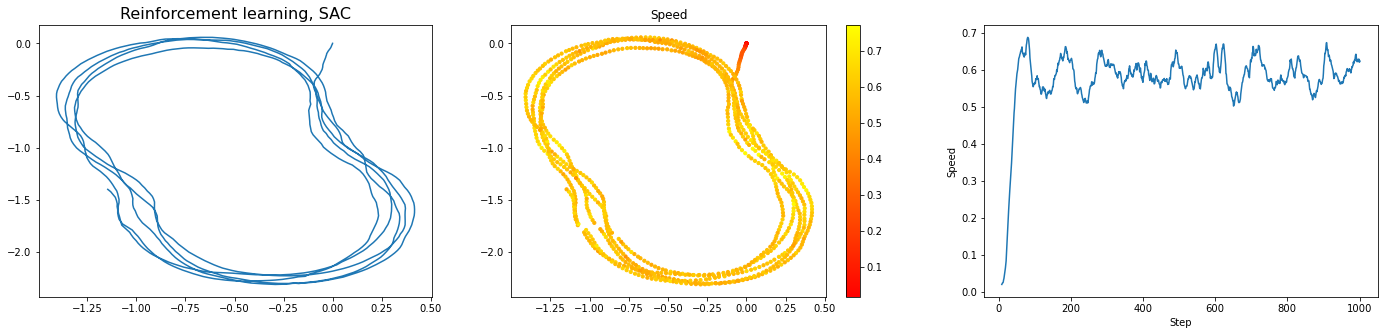

Average speed: 0.59


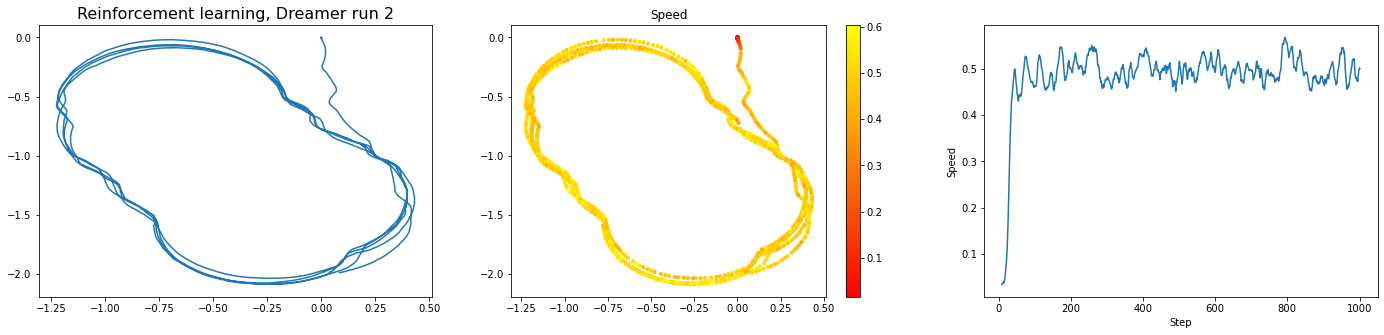

Average speed: 0.50


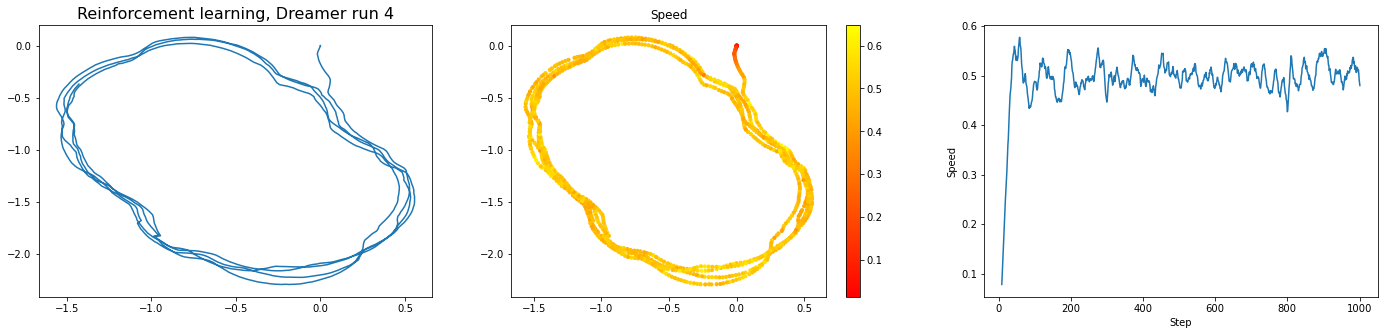

Average speed: 0.50


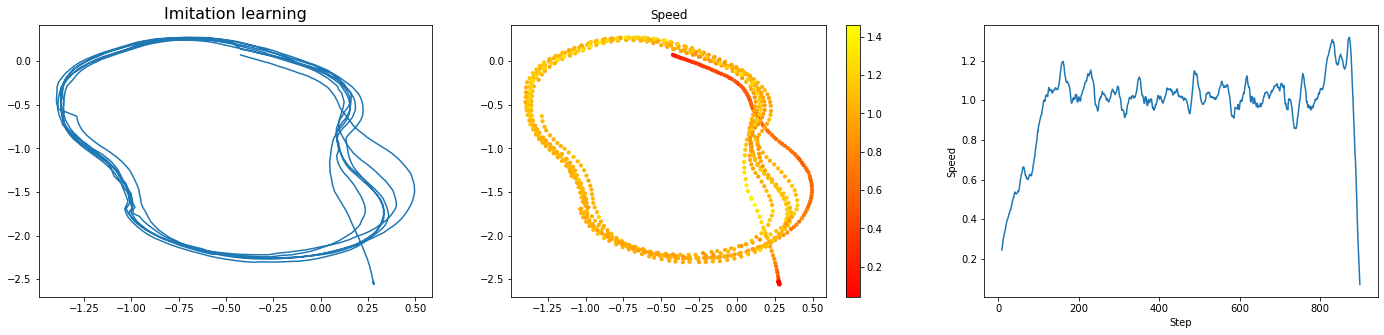

Average speed: 1.02


In [188]:
def plot_episode(e, title):
    plt.figure(1, (24, 5))
    plt.subplot(1, 3, 1)
    plt.title(title, size=16)
    plt.plot(e.PosX, e.PosZ)
    plt.subplot(1, 3, 2)
    plt.scatter(e.PosX, e.PosZ, c=e.Speed, cmap=plt.cm.autumn, s=10)
    plt.colorbar()
    plt.title("Speed")
    plt.subplot(1, 3, 3)
    plt.ylabel("Speed")
    plt.xlabel("Step")
    plt.plot(np.arange(len(e)), e.Speed.rolling(10).mean())
    plt.show()
    print(f"Average speed: {e.Speed.values[200:800].mean():.2f}")

    
data = vs.load_data("../records/local_control/record_2020-10-11T19:21:10.105673.csv")
mean_speed = data.groupby("Episode").mean().Speed[data.groupby("Episode").max().Step > 1000]

e_rl = data[(data.Episode == 26) & (data.Step > 20)]

data = vs.load_data("../records/dreamer_local_control/record_2020-10-15T13:36:08.118514.csv")
mean_speed = data.groupby("Episode").mean().Speed[data.groupby("Episode").max().Step > 1000]

e_dr = data[(data.Episode == 17) & (data.Step > 20)]

data = vs.load_data("../records/dreamer_local_control/record_2020-10-15T15:36:07.760681.csv")
mean_speed = data.groupby("Episode").mean().Speed[data.groupby("Episode").max().Step > 1000]

e_dr2 = data[(data.Episode == 25) & (data.Step > 20)]

data = vs.load_data("../records/local_control/imitation_record_2020-10-11T20:33:52.630958.csv")
mean_speed = data.groupby("Episode").mean().Speed[data.groupby("Episode").max().Step > 1000]

e_im = data[-1100:-200]

plot_episode(e_rl, "Reinforcement learning, SAC")
plot_episode(e_dr, "Reinforcement learning, Dreamer run 2")
plot_episode(e_dr2, "Reinforcement learning, Dreamer run 4")
plot_episode(e_im, "Imitation learning")

## Video of Episode 2 

In [186]:
image_folder = "ims_dreamer_video"

if not os.path.isdir(image_folder):
    os.mkdir(image_folder)

data = vs.load_data("../records/dreamer_local_control/record_2020-10-15T13:36:08.118514.csv")
data = data[data.Step > 20]

skip = 5
trail_width = 2

image_counter = 1

for j in range(1, data.Episode.max()):
    e_dr = data[data.Episode == j]
    
    for i in range(1, int(len(e_dr) / skip)):
        plt.figure(1, (12, 12))
        for e in range(1, j):
            e_prev = data[data.Episode == e]
            plt.plot(e_prev.PosX, e_prev.PosZ, color="k", linewidth=0.2)
            if len(e_prev) < 1000:
                plt.plot(e_prev.PosX.values[-1], e_prev.PosZ.values[-1], marker="x", color="k", linestyle="None")
                     
        step = i * skip
        step_dr = e_dr.iloc[:step]
        plt.plot(step_dr.PosX, step_dr.PosZ, linewidth=trail_width, color="C0")
        plt.plot(step_dr.PosX.values[-1], step_dr.PosZ.values[-1], linestyle="None", marker="o", color="C0", label="Dreamer") 
        plt.ylim(-3, 1)
        plt.xlim(-2, 1)
        plt.legend()
        plt.savefig(f"{image_folder}/figure_{image_counter:04d}.png", dpi=70)
        image_counter += 1
        plt.show()
        print(f"Episode {j} step {step}")

In [ ]:
!ffmpeg -r 30 -f image2 -i ./ims_dreamer_video/figure_%04d.png -vcodec libx264 -crf 15  -pix_fmt yuv420p ./ims_dreamer_video/video.mp4

In [197]:
#Video("./ims_dreamer_video/video.mp4")

## Speed normalized head to head race SAC vs Dreamer

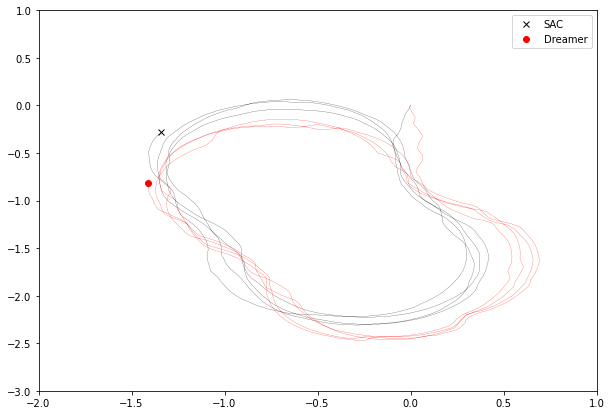

In [159]:
import datetime
image_folder = f"images_{datetime.datetime.now().isoformat}"
image_folder = "ims11"

if not os.path.isdir(image_folder):
    os.mkdir(image_folder)

data = vs.load_data("../records/local_control/record_2020-10-11T19:21:10.105673.csv")
e_rl = data[(data.Episode == 26) & (data.Step > 20)]

data = vs.load_data("../records/dreamer_local_control/record_2020-10-15T14:55:54.638306.csv")
e_dr = data[(data.Episode == 25) & (data.Step > 20) & (data.Step % 6 != 0)]

e_rl = e_rl[:len(e_dr)]

skip = 2
trail_width = 0.2
for i in range(1, int(len(e_rl) / skip)):
    step = i * skip
    clear_output(wait=True)
    step_rl = e_rl.iloc[:step]
    step_dr = e_dr.iloc[:step]
    plt.figure(1, (10, 7))
    plt.plot(step_rl.PosX, step_rl.PosZ, linewidth=trail_width, color="k")
    plt.plot(step_rl.PosX.values[-1], step_rl.PosZ.values[-1], marker="x", linestyle="None", color="k", label="SAC")
    plt.plot(step_dr.PosX, step_dr.PosZ, linewidth=trail_width, color="r")
    plt.plot(step_dr.PosX.values[-1], step_dr.PosZ.values[-1], linestyle="None", marker="o", color="r", label="Dreamer") 
    plt.ylim(-3, 1)
    plt.xlim(-2, 1)
    plt.legend()
    plt.savefig(f"{image_folder}/figure_{i:04d}.png", dpi=70)
    plt.show()

In [ ]:
!ffmpeg -f image2 -i ./ims11/figure_%04d.png -vcodec libx264 -crf 15  -pix_fmt yuv420p ./ims11/video.mp4

In [196]:
#Video("./ims11/video.mp4")